In [167]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [168]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

columns =  eye_data_names + channels

#data, header = pyxdf.load_xdf('data/LSLDataV2/LSLDataLeftFourTimes2/eeg-and-eyetracking.xdf')


In [169]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [170]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [171]:

def init_data(data, shift = 0):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
        if shift != 0:
            df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
        return stream, df_stream, df_stream_ts

#stream, df_stream, df_stream_ts = init_data(data)
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

#left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [172]:
#avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

In [173]:
#start, end = get_time_stamps(left_blinks)
flip = False
chosen_channel = 'AUX_1'

In [174]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = (df_norm + plus) *(-1 if flip else 1) *scale
    peaks, _ = signal.find_peaks(y[rang-7:rang+30])
    peaks = [peak + rang-7 for peak in peaks]

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

def get_peaks(df, start, end, column, rang=50, scale=1, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()

    peaks, _ = signal.find_peaks(y[rang-20:rang+20])
    peaks = [peak + rang-20 for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0
    peak = peaks[np.argmax([y[i] for i in peaks])]+ start - rang
    return  peak if end + rang > peak > start - rang else start



In [175]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

In [176]:

def run_files(paths, path='data/LSLData120hz/', both = True, plot = False, shift_init=0):
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):
        data, header = pyxdf.load_xdf(path+str(y)+'/dejittered-fir-eeg-and-dejittered-eyetracking.xdf')
        stream, df_stream, df_stream_ts = init_data(data,shift_init)
        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(both_blink)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())
        peaks = []
        for i in range(len(start)):
            if i == 10:
                continue
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=50, scale=5, flip=both))

        shift = find_shift(start, peaks)
        peak_info.append(shift)

    n = len(max(peak_info, key=len))
    t = [x + [None]*(n-len(x)) for x in peak_info]
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    df_peak['time between index (s)'] = [i[0] for i in avg_time]
    df_peak['Sum (indexes)'] = df_peak.sum(axis=1)
    df_peak['Avg (indexes)'] = round(df_peak.loc[:, 0:9].mean(axis=1),3)
    df_peak['Avg time (ms)'] = round(df_peak['Avg (indexes)']*df_peak['time between index (s)'],5)*1000
    if plot:
        plot_table(df_peak)
    return df_peak



In [177]:


paths = [name for name in os.listdir("./data/LSLData120hz")]
both = [name for name in paths if "Both" in name and not "bad" in name]


df_both = run_files(both, both=flip , plot=False)
#df_both = df_both.drop(df_both.columns[[1]], inplace=True, axis=1)
display(df_both)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLDataBoth10Times120_14,-14,15,-18,-16,13,-15,-18,-16,-17,12,0.008333,-73.991667,-7.4,-61.67
LSLDataBoth10Times120_5,-17,-18,-15,-16,-12,-16,-11,-14,-15,-16,0.008333,-149.991667,-15.0,-125.00
LSLDataBoth10Times120_10,-11,-17,-18,-17,-16,-18,19,-15,-18,-18,0.008333,-128.991667,-12.9,-107.50
LSLDataBoth10Times120_7,-16,15,-15,-15,-14,-17,-16,-17,-16,-17,0.008333,-127.991667,-12.8,-106.67
LSLDataBoth10Times120_11,-17,18,-18,-17,15,-18,-17,17,-15,-17,0.008333,-68.991667,-6.9,-57.50
LSLDataBoth10Times120_8,-14,-18,-18,15,-15,18,-16,-16,-16,-18,0.008333,-97.991667,-9.8,-81.67
LSLDataBoth10Times120_9,-16,-16,-18,-12,-17,-17,-17,-18,-18,-16,0.008333,-164.991667,-16.5,-137.50
LSLDataBoth10Times120_12,16,-15,-17,-17,-18,15,-18,18,-17,-18,0.008333,-70.991667,-7.1,-59.17
LSLDataBoth10Times120_4,-15,-18,-14,-15,-15,-18,-15,-15,-14,-12,0.008333,-150.991667,-15.1,-125.83
LSLDataBoth10Times120_3,-14,-18,-14,-13,-14,-16,-18,-15,-15,-15,0.008333,-151.991667,-15.2,-126.67


In [178]:
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    print(avg_offset_index)
    return avg_offset, avg_offset_index


In [179]:
print("(ms, Number of indexes to shift) ---- Both")
print(get_offset(df_both))
df_both_shift = run_files(both, both=flip , plot=False, shift_init=round(get_offset(df_both)[1]))
#df_both_shift.loc['Average']= df_both_shift.sum(numeric_only=True, axis=0)/df_both_shift.shape[0]
display(df_both_shift)


print(get_offset(df_both_shift))

(ms, Number of indexes to shift) ---- Both
-11.484615384615383
(-95.70615384615387, -11.484615384615383)
-11.484615384615383


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLDataBoth10Times120_14,-3,-8,-7,-11,-12,-8,-18,-5,-14,-18,0.008333,-103.991667,-10.4,-86.67
LSLDataBoth10Times120_5,-6,-7,-4,-5,-1,-5,0,-3,-4,-5,0.008333,-39.991667,-4.0,-33.33
LSLDataBoth10Times120_10,-8,-6,-12,-11,-17,-17,-17,-9,-16,-12,0.008333,-124.991667,-12.5,-104.17
LSLDataBoth10Times120_7,-8,-8,-4,-8,-3,-16,-10,-6,-11,-15,0.008333,-88.991667,-8.9,-74.17
LSLDataBoth10Times120_11,-16,-14,-9,-6,-18,-10,-6,-17,-4,-11,0.008333,-110.991667,-11.1,-92.50
LSLDataBoth10Times120_8,-3,-9,-7,-10,-10,-8,-5,-5,-8,-7,0.008333,-71.991667,-7.2,-60.00
LSLDataBoth10Times120_9,-5,-12,-7,-16,-17,-14,-6,-13,-15,-8,0.008333,-112.991667,-11.3,-94.17
LSLDataBoth10Times120_12,-11,-8,-6,-6,-15,-14,-14,-12,-13,-14,0.008333,-112.991667,-11.3,-94.17
LSLDataBoth10Times120_4,-4,-7,-3,-4,-4,-7,-4,-4,-3,-1,0.008333,-40.991667,-4.1,-34.17
LSLDataBoth10Times120_3,-3,-7,-3,-2,-3,-8,-7,-4,-4,-4,0.008333,-44.991667,-4.5,-37.50


-8.461538461538462
(-70.51384615384616, -8.461538461538462)


In [180]:
import statistics
from scipy.stats import sem

standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
print("Standard devation")
print("Both: " + str(standard_de_both))

print("-------- SE ----------")
print("Both: " + str(se_both))

Standard devation
Both: 44.699625937745374
-------- SE ----------
Both: 12.39744563943085


In [181]:
standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
print("Standard devation - After shift")
print("Both: " + str(standard_de_both_shift))
print("-------- SE - After shift ----------")
print("Both: " + str(se_both_shift))

Standard devation - After shift
Both: 25.138709373680246
-------- SE - After shift ----------
Both: 6.97222351121472


[-1.0417, -0.9417, -0.9417, -0.925, -0.8667, -0.8332999999999999, -0.7417, -0.7417, -0.6, -0.4833, -0.375, -0.3417, -0.3333]


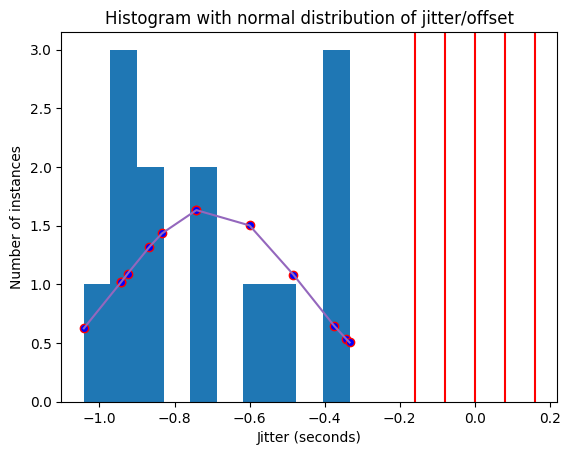

In [182]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.axvline(x=0, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-0.08, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-0.08*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=0.08, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=0.08*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.title("Histogram with normal distribution of jitter/offset")
plt.xlabel("Jitter (seconds)")
plt.ylabel("Number of instances")
plt.show()